In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sns.set_style('darkgrid')

# Data Analysis of various factors on Fermentation Time of Ales

In this project, I did an analysis of factors affecting fermentation time in a large scale craft brewery. In production brewing, the variations in the length of fermentation has numerous effects on not only the quality of the beer but also the production time from the beginning of the brewing process to delivery of the finished product.

<b>The brewery in this study was having trouble with lagging starts at the beginning of the fermentation process. On the surface it seemed there was no rhyme or reason as to which fermentations would start quickly and finish in time for scheduled delivery, and which ones would stall for a few days and cause delays in production.</b>

I used Python’s pandas and seaborn libraries to explore the effects of <b>temperature, yeast generation (or number of re-uses), and tank size </b> on fermentation lag to try to explain and correct what was causing the seemingly random delays.


### Data cleaning and feature engineering:
    
#### The initial data required extensive cleaning...

Original data files were individual excel sheets (one per day), sent out by the Brewery Laboratory. Each contained a table of FV's (Fermentation vessels) with relevant daily data logged in each column (dates, gravity readings, temperatures, etc).
    
Below the FV table was a second unrelated table of packaging tanks and yeast handling vessels. This table did not conform to the FV columns and is unusable for our master dataset.
    
Usable columns can be identified by having a value of an FV-identifier in the FV column, all other rows can be discarded.

Several columns in the initial excel files had multiple features combined into one cell which were separated by varying numbers of spaces or different characters that needed to be extracted uniformly into their own columns.

Null values in the initial excel files we designated either by empty cells, or dashes and underscores of varying length.

Numerous typos were also found and cleaned during the initial processing of the dataframe.
    

### Data Cleaning user defined functions:

Replacing missing data designated by spaces,  "___" or "---" of varying length were replaced with NaN

In [3]:
def na_cleaning(item):
    if '__' in str(item) or '--' in str(item):
        return np.nan
    else:
        return item

Some tanks were designated as Empty (or Empy) on any given day. These rows were unneccecary to the analysis

In [4]:
def drop_empty_tanks(item):
    if pd.isnull(item):
        return item
    else:
    
        item = str(item).strip()
        if item == 'Empty' or item == 'Empy':
            return np.nan
        else:
            return item

Since the analysis is an exploration of the fermentation process, any tanks designated as "Done" fermenting could be labeled as 'Finished' and removed from the dataset

In [5]:
def get_status(item):
    if 'Done' in str(item):
        return 'Finished'
    else:
        return 'Active'

Various other pieces of information were extracted through string parsing using identifying characters before or after the pertinent information

In [6]:
def get_brew_no(item):
    if pd.isnull(item):
        return item
    elif '#' in item:
    
        item = item.split('#')[1][:4]
        return int(item)
    else:
        return item

In [7]:
def extract_yeast_gen(text):
    text=str(text)
    if pd.isnull(text):
        return np.nan
    elif '__' in text or '--' in text:
        return np.nan
    elif 'G/' in text:
        return 'G' + text.split('G/')[1][:2]
    
    elif 'G' in text:
        return 'G' + text.split('G')[1][:2]
    elif 'g' in text:
        return 'G' + text.split('g')[1][:2]
    else:
        return np.nan
        
    

In [8]:
def yeast_gen_post_proc(text):
    text = str(text)
    if text == 'nan':
        return np.nan
    elif text == 'G':
        return np.nan
    elif text == 'G10' or text == 'G11':
        return text
    else:
        return text[:2]

Regular expressions were used to extract average temp from a column which contained a single string with multiple temperatures separated by a "/"

In [9]:
def get_temp(temp):
    try:
        temp_total = 0
        temp = str(temp)
        num_list = re.findall(r'\d\d',temp)
        for num in num_list:
            temp_total += int(num)
        return temp_total/len(num_list)
       
    except:
        return np.nan
        

An exploration of unique values in the data set uncovered some typos or variations in the Beer Names were found and corrected

In [10]:
def fix_beer_name(name):
    if name == 'Oktoberfest':
        return 'Ofest'
    elif name == 'PIlsner':
        return 'Pilsner'
    elif name == 'Witt':
        return 'Wit'
    elif name == 'Sexual Choc':
        return 'Sexual Chocolate'
    else:
        return name

Beer brands were split into Ales and Lagers as their fermentation properties differ significantly

In [11]:
def get_style(name):
    lager_list = ['Pilsner', 'Ofest', 'Helles']
    if name in lager_list:
        return 'Lager'
    else:
        return 'Ale'

Attenuation is a measurement of how thoroughly the beer is fermented at any measured point. This was calculated by the difference in starting gravity(density) and current or finished gravity divided by the original starting gravity.

In [12]:
def get_atten(og, grav_today):
    try:
        return float((og - grav_today)/og)
    except:
        return np.nan

As brewsize may be a factor, some typos were corrected using Domain knowledge and fermentations were given a more uniform 'brewsize' based on the general volume and tank size.

In [13]:
def get_brew_size(vol):
    vol_list = [50,100,150,200,250,300,350,400]
    if pd.isnull(vol):
        return vol
    elif vol in vol_list:
        return vol
    elif vol == 494.5:
        return 400
    else:
        return int(vol/50)*50
    

#### Preprocessing function:

All data cleaning steps and function calls are in the preprocessing function below which returns the cleaned and formatted datatset used for Exploration and Analysis

In [14]:
def preprocessing(file):
        
    # Create list of FV (tank) names to use to isolate usable data
    tank_names = ['FV1', 'FV2', 'FV3', 'FV4', 'FV5', 'FV6', 'FV7', 'FV8', 'FV9',
       'FV10', 'FV11', 'FV12', 'FV13', 'FV14', 'FV15', 'FV16', 'FV17',
       'FV18', 'FV19', 'FV20','FV21','FV22']
    
    # Read in file as pandas DataFrame
    df = pd.read_excel(file,sheet_name='data')
    
    # Rename 'Unnamed column' as 'FV'
    df = df.rename(columns = {'Unnamed: 0':'FV'})
    
    # Drop all rows that are not an FV (BBTs and Yeast info)
    df=df.loc[df['FV'].isin(tank_names)]
    
    # Drop unnecessary columns 
    df = df[['date','FV','Beer','BBLS','Date/ Brew#','Yeast','OG (plato)','Grav today (plato)','ST      (*F)','AT       (*F)']]
    
    # na values in original data have '__' or '--', replace these with np.nan
    for i in df.columns:
        df[i] = df[i].apply(na_cleaning)
    
    # drop empty tanks from Beer column
    df['Beer'] = df['Beer'].apply(drop_empty_tanks)
    df = df.dropna(subset=['Beer'])
    df = df.reset_index().drop('index',axis=1)
    
    # convert date column to datetime obj
    df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))
    
    # extract year from date column
    df['year'] = df['date'].apply(lambda x: str(x.year))
    
    # get status and keep only active tanks
    df['status'] = df['Grav today (plato)'].apply(get_status)
    df = df[df['status']=='Active']
    df = df.drop('status', axis=1)
    df = df.reset_index().drop('index',axis=1)
    
    # get brew_no
    df['brew_no'] = df['Date/ Brew#'].apply(get_brew_no)
    
    #get brew_date
    data_dict = df.groupby('brew_no')['date'].min().to_dict()
    df['brew_date'] = df['brew_no'].map(data_dict)
    
    #drop very early and very late data (incomplete)
    df = df[(df['brew_no'] > 3006) & (df['brew_no']<7853 )]
    df = df.reset_index().drop('index',axis=1)

    # get current day of fermentation
    df['Fday'] = (df['date']-df['brew_date'])
    df['Fday'] = df['Fday'].apply(lambda x: int(x.days) if pd.notnull(x) else x)
    
    # Drop long/barrel aged beers
    df = df[df['Beer'].str.contains("Dead & Berried|BASC|BA Porter|BASC-Coffee")==False]
    
    # get temp
    df['temp'] = round(df['AT       (*F)'].apply(get_temp),1)
    
    # fix beer name typos
    df['Beer'] = df['Beer'].apply(fix_beer_name)
    
    # get style
    df['Beer_Style'] = df['Beer'].apply(get_style)
    
   
    # Extract Yeast Gen from Yeast Col
    df['Yeast_Gen'] = df['Yeast'].apply(extract_yeast_gen)
    df['Yeast_Gen'] = df['Yeast_Gen'].apply(yeast_gen_post_proc)
    df['Yeast_Gen'] = df['Yeast_Gen'].apply(lambda x: int(x.replace('G','')) if pd.notnull(x) else x)
    
    # map total ferment days for each brew_no into separate column
    total_f_days = df.groupby('brew_no')['Fday'].max().to_dict()
    df['ferment_length'] = df['brew_no'].map(total_f_days)
    
    # map initial temp for each brew_no to separate column
    temp_dict = df[df['Fday']==1].groupby('brew_no')['temp'].min().to_dict()
    df['initial_temp'] = df['brew_no'].map(temp_dict)
    
    # Create column that measures % attenuation for each day based on starting grav and current grav
    df['Atten'] = df.apply(lambda x: get_atten(x['OG (plato)'], x['Grav today (plato)']), axis=1)
    
    # Convert plato col to float (or NaN if not possible)
    df['OG (plato)'] = df['OG (plato)'].apply(lambda x: float(x) if pd.notnull(x) else np.nan)
    
    # Group fermentation batches into standard brew sizes
    df['BBLS'] = df['BBLS'].apply(get_brew_size)
    
    # return only dataframe with necessary columns
    df = df[['date', 'brew_no', 'brew_date','FV', 'Beer', 'BBLS','Yeast_Gen','OG (plato)',
       'Grav today (plato)','Atten','temp', 'year',  'Fday','Beer_Style','ferment_length','initial_temp' ]]
    
    return df

In [15]:
df = preprocessing('master_data.xlsx')

# EDA

## QUESTIONS TO ANSWER:

This brewery was experiencing lagging starts to their fermentation processes but only sporadically. The delayed starts led to longer than anticipated ferment times and were setting back delivery times of the final product to distribution centers.

To understand what was causing the seemingly random slow fermentations, I explored a variety of features that could potentially be affecting the process and tried to asnwer the following questions...

1. What is causing the delayed and slow fermentations?
2. What steps within our control can we take to rectify the problem?

### What does a healthy, on time fermentation look like?
Healthy fermentation starts on the first or second day and most of the Attenuation happens on the first active day.

Usually, we will see a significant drop of several degrees Plato on day 1 or day 2

Text(0, 0.5, 'Gravity in deg Plato')

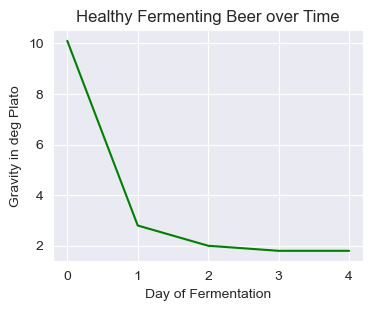

In [16]:
plt.figure(figsize=(4,3))
healthy = df[df['brew_no']==4596][['Fday','Grav today (plato)']]
sns.lineplot(data=healthy,x='Fday',y='Grav today (plato)',color='green')
plt.title('Healthy Fermenting Beer over Time')
plt.xlabel('Day of Fermentation')
plt.ylabel('Gravity in deg Plato')


### What does an unhealthy fermentation look like?

An unhealthy fermentation is one where Attenuation is minimal for several days before any significant drop.

This problem delays packaging and ship dates and leaves the beer vulnerable to microbiological contamination as no alcohol has been produced inside it yet.

Text(0, 0.5, 'Gravity in deg Plato')

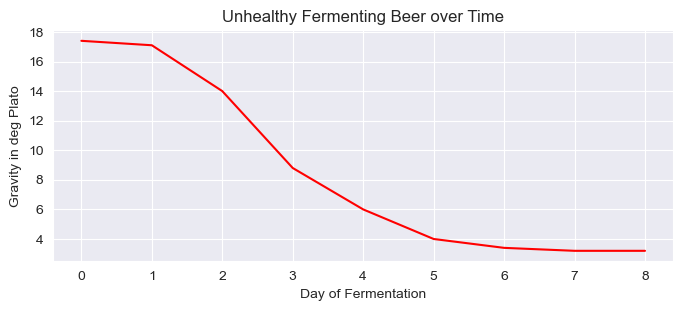

In [17]:
plt.figure(figsize=(8,3))
unhealthy = df[df['brew_no']==3528][['Fday','Grav today (plato)']]
sns.lineplot(data=unhealthy,x='Fday',y='Grav today (plato)',color='red')
plt.title('Unhealthy Fermenting Beer over Time')
plt.xlabel('Day of Fermentation')
plt.ylabel('Gravity in deg Plato')

### Exploring typical length of fermentation for ales

Most of this analysis will focus on <b>ales</b> as a vast majority of this brewery's products were ales (89%)
    

Text(0.5, 1.0, 'Number of Ale vs Lager Fermentations in Dataset')

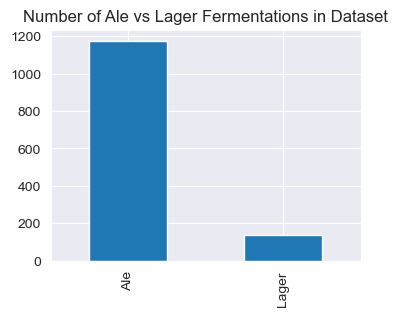

In [18]:
plt.figure(figsize=(4,3))
df.groupby('brew_no')['Beer_Style'].max().value_counts().plot(kind='bar')
plt.title('Number of Ale vs Lager Fermentations in Dataset')

#### Most Ale fermentations fall in the range of 5-6 days 

Text(0.5, 1.0, 'Distribution of fermentation lengths for Ales')

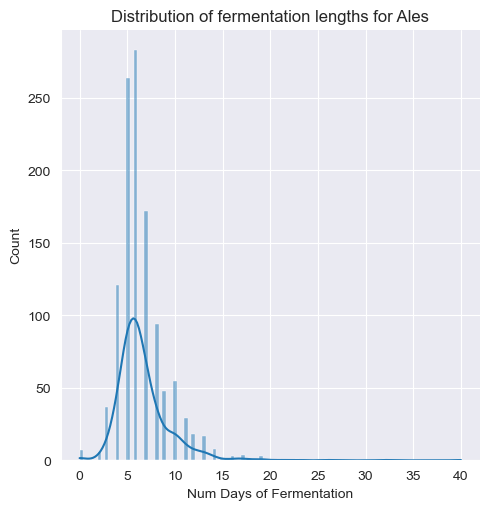

In [19]:
ales = df[df['Beer_Style']=='Ale']
ales_fday = ales.groupby('brew_no')['Fday'].max().reset_index()
sns.displot(data=ales_fday,x='Fday',kde=True)
plt.xlabel('Num Days of Fermentation')
plt.title('Distribution of fermentation lengths for Ales')

### Comparing Ales to Lagers
Ales typically ferment faster with a median time of 6 days comapred to Lagers, which had a median fermentation time of 11 days

Text(0, 0.5, 'Ferment Days')

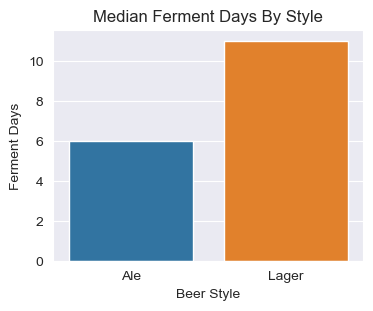

In [20]:
f_lengths = df.groupby('brew_no')[['Fday','Beer_Style']].max().reset_index()
f_lengths = f_lengths.groupby('Beer_Style')['Fday'].median().reset_index()
f_lengths

plt.figure(figsize=(4,3))
sns.barplot(data=f_lengths,x='Beer_Style',y='Fday')
plt.title('Median Ferment Days By Style')
plt.xlabel('Beer Style')
plt.ylabel('Ferment Days')

# Examining possible causes of Ferment Lag

#### Initial look at data correlations

Text(0.5, 1.0, 'Correlation of numerical features in dataset')

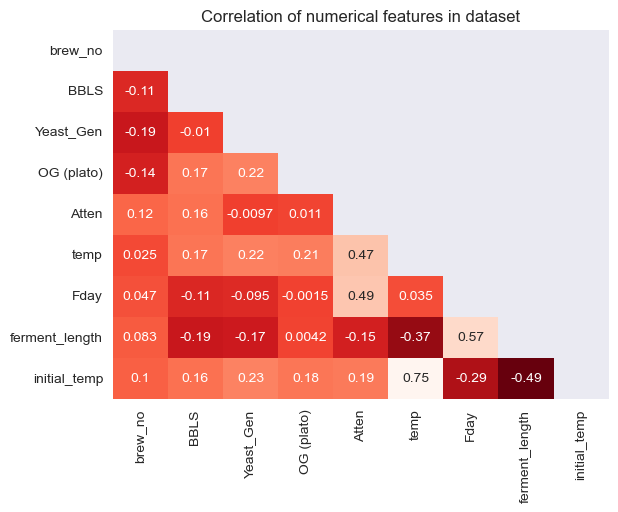

In [21]:
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(),cmap='Reds_r',annot=True,cbar=False,mask=mask)
plt.title('Correlation of numerical features in dataset')

#### Explore correlations between Ferment Length and other features in dataset

We can eliminate some factors from the chart below:

1. brew_no is an arbitrary id given to each fermentation and should have no direct meaningful effect on ferment length
2. Fday is directly related to ferment_length as a marker of what day each row is on
3. Temp is row specific to each day of ferment, not to overall ferment length

Text(0.5, 1.0, 'Correlation of Relevant Features to Ferment Time')

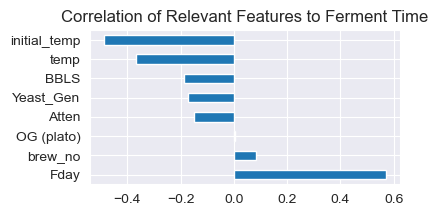

In [31]:
plt.figure(figsize=(4,2))
df.corr()['ferment_length'].sort_values(ascending=False)[1:].plot(kind='barh')
plt.title('Correlation of Relevant Features to Ferment Time')

#### Initial observation suggest that initial temp and Yeast Generation have the biggest correlation with a shorter ferment time

Text(0.5, 1.0, 'Correlation of Relevant Features to Ferment Time')

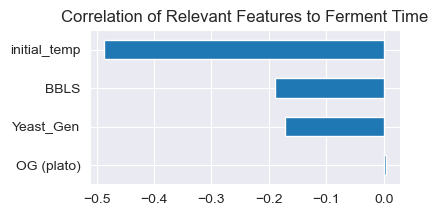

In [30]:
plt.figure(figsize=(4,2))
relevant_feats = df[['initial_temp','Yeast_Gen','OG (plato)','ferment_length','BBLS']]
relevant_feats.corr()['ferment_length'].sort_values(ascending=False)[1:].plot(kind='barh')
plt.title('Correlation of Relevant Features to Ferment Time')

# Effect of initial temperature on ferment days 
The initial temperature is the temperature of the beer at the start of fermentation.

Different yeast strains respond better to different temperature ranges

In ales:
    Outliers removed, temp range 62-75

### Overall, beers with warmer initial temperatures produced shorter fermentations

Text(0, 0.5, 'Length of Ferment in Days')

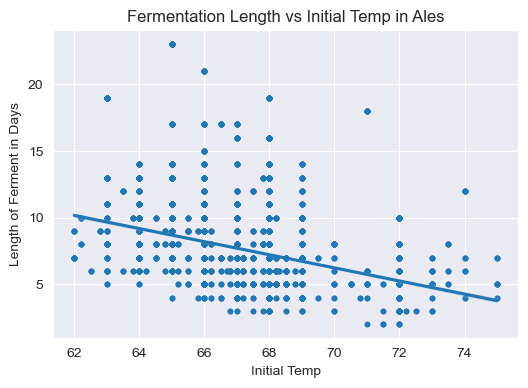

In [24]:
plt.figure(figsize=(6,4))
ales_ave_temp = df[(df['Beer_Style']=='Ale') & (df['initial_temp']>=62) & (df['initial_temp'] <= 75) & (df['ferment_length']<25) ]
sns.regplot(data = ales_ave_temp, x='initial_temp', y='ferment_length',marker='.')
plt.title('Fermentation Length vs Initial Temp in Ales')
plt.xlabel('Initial Temp')
plt.ylabel('Length of Ferment in Days')

### Comparing the effect of initial temperature on Attenuation over the first 4 days


#### Low initial fermentation temperature has more drastic effect during first few days

In the first and second day, we see a clear correlation that cooler starting fermentations have less attenuation than warmer starting fermentations. 

By day 4, the cooler starting fermentations start to catch up to where the warmer starting fermentations were a few days earlier.

As the yeast ferments, it produces heat that warms the fermenting liquid and produces better results. But <b>the cooler start has delayed the process.</b>

### Below shows the % attenuation for ales in the first 4 days of fermentation with an initial temp range of 60-80F

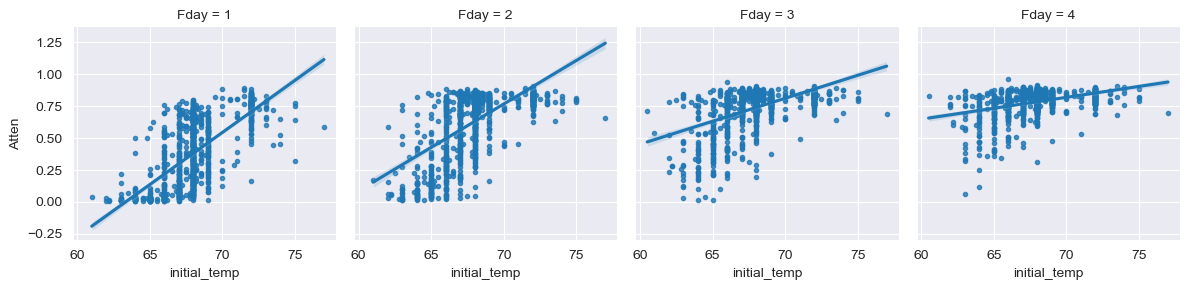

In [25]:
first_four_days = df[(df['Fday'] < 5) &(df['Fday']>0)& (df['Atten'] > 0) & (df['initial_temp']>60) & 
                 (df['initial_temp']<80) & (df['Beer_Style']=='Ale')][['Fday','Atten','Beer_Style','initial_temp']]

sns.lmplot(data=first_four_days, x="initial_temp", y="Atten", col="Fday", height=3,markers='.')


#### CONCLUSION: Warmer initial temperature results in quicker start to fermentation and shorter overall fermentation length

Temperature is controlled manually by the brewer during the filling process. Human error during this process could result in lower initial temperature and therefore lead to slower fermentation starts and longer overall fermentation length.

Preventing this error and ensuring the temperature is warm enough would likely result in shorter ferment lengths overall.

# Effect of Brew size (BBL) on ferment length

Brewing tanks were filled in 50bbl increments and tank sizes ranged from 50bbl (1 brew) to 400bbl (8 brews)

The brewing cycle was about 5 hrs. So in tanks with multiple brews, 50bbl was added to a tank every 5 hrs. Consequently, a 50bbl tank is filled in ~5 hrs and a 400bbl tank is filled in ~35hrs.

Yeast was added during the first 50bbl filling cycle and typically, the conditions for fermentation to start were in place as soon as the first 50bbl fill was complete

Here we examine the effect of larger tanks filled over longer periods of time on total fermentation time.

Text(0, 0.5, 'Ferment Length in Days')

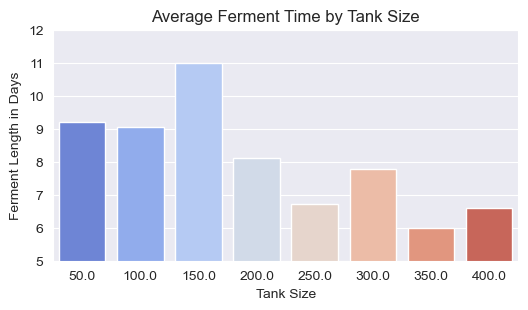

In [26]:
brewsize=df.groupby('BBLS').mean()['ferment_length'].reset_index()
plt.figure(figsize=(6,3))
sns.barplot(data=brewsize,x='BBLS',y='ferment_length',palette='coolwarm')
plt.ylim(5,12)
plt.title('Average Ferment Time by Tank Size')
plt.xlabel('Tank Size')
plt.ylabel('Ferment Length in Days')

#### CONCLUSION: Larger tanks resulted in shorter overall fermentation time.

In this dataset, the Fermentation Day count begins after the final filling cycle. For larger tanks, this means the fermentation process has been started for nearly 30 hrs before the fermentation_day count has even begun.

The multiple fills for larger tanks also allows not only time for temperature to adjust, but for brewers to compensate with warmer or cooler subsequent fills to adjust the overall initial temp inside the tank.


# Effect of re-using yeast on overall ferment time

Yeast is reused multiple times before fresh yeast is brought into the brewery. At the end of one fermentation it is transferred off of a finished tank, into a new tank to start the next fermentation. Over time, the yeast can become worn out or mutate and producese varying effects on the finished product.

In this section I'll explore the effect of yeast generation on the overall length of fermentation. 

#### First, a look at how frequently yeast is re-used, and which generations contain the most data

This brewery typically tried to phase out yeast after Gen 6 or 7. Below we can see that there is very little data on yeast older than 8 Gens.

For the purposes of this analysis, we will set a minimum limit of 50+ observations and drop data on Gens 8-11

Text(0.5, 1.0, 'Frequency of Yeast Generations Used')

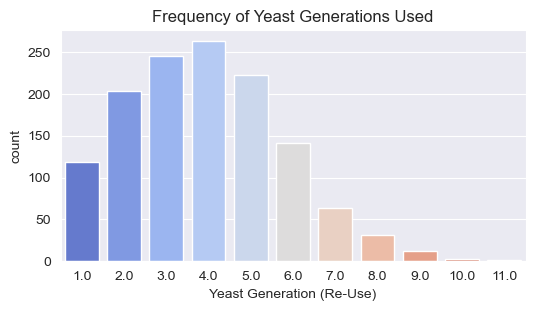

In [27]:
plt.figure(figsize=(6,3))
ygen_count = df.groupby('brew_no')['Yeast_Gen'].min().reset_index()
sns.countplot(data=ygen_count,x='Yeast_Gen',palette='coolwarm')
plt.xlabel('Yeast Generation (Re-Use)')
plt.title('Frequency of Yeast Generations Used')

#### Yeast Generation does not appear to have large impact on fermentation length

Overall, Gen 3 was observed to have the shortest ferment time but the variance is minimal.

All values in 



(2.0, 12.0)

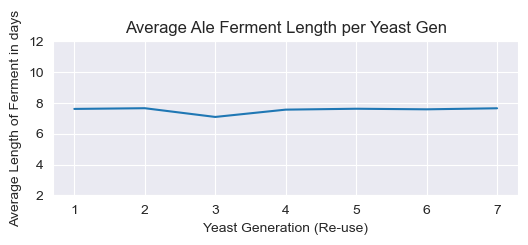

In [28]:
yeast_gens = df[df['Beer_Style']=='Ale']
yeast_gens = yeast_gens.groupby('Yeast_Gen').mean().reset_index()
yeast_gens = yeast_gens[(yeast_gens['Yeast_Gen'] < 8)]

plt.figure(figsize=(6,2))
sns.lineplot(data=yeast_gens,x='Yeast_Gen',y='ferment_length')
plt.title('Average Ale Ferment Length per Yeast Gen')
plt.xlabel('Yeast Generation (Re-use)')
plt.ylabel('Average Length of Ferment in days')
plt.ylim(2,12)

#### CONCLUSION: Yeast Gen has little to no effect on ferment length

With less than 1 day difference in observed ferment length by Yeast Generation, there doesn't appear to be a meaningful correlation between Yeast Gen and Ferment length.

Although Gen 3 performed the best by a small margin, it seems an unlikely cause of the delay in the process.

In [29]:
yeast_gens[['Yeast_Gen','ferment_length']]

,Yeast_Gen,ferment_length
0,1.0,7.610475
1,2.0,7.655906
2,3.0,7.088959
3,4.0,7.563523
4,5.0,7.621487
5,6.0,7.584130
6,7.0,7.651822


# Overall Conclusions

1. The initial temperature at the beginning of the fermentation day count was shown to have the biggest impact on how long the resulting fermentation process would take
<p>
    
2. By raising the initial temperature of fermentation, we can increase the likeliness of a quick and healthy fermentation
<p>
    
3. Based on the domain knowledge of how temperature is regulated during the filling process, more consideration should be placed on ensuring cooler temperatures are avoided during this process.